# Analysis the nepotistic level of Karan Johar's movies

In [190]:
import wikipedia
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup as bs
import os
from os import path
import copy
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from pandas import ExcelWriter
import plotly.graph_objects as go
import plotly.express as px

categories_of_interest = ['Directed by', 'Produced by', 'Starring', 'Release date'] #scrapped from Wiki
categories_accounted = ['Directors', 'Producers', 'Actors'] # Accounted in analysis

color_teal = '#258193'
color_plum = '#910838'
color_navy = '#064273'

### Get Dharma Production movies table from Wiki

In [71]:
def get_wiki_table(topic_url, table_class):
    html = requests.get(topic_url).text
    soup = bs(html, 'html.parser')
    tables = soup.find_all('table', {'class': table_class})
    return tables

# Get Wiki urls of Karan Johar's movies as Producer, Director, and Writer
subject_url = 'https://en.wikipedia.org/wiki/List_of_Dharma_Productions_films'
tables = get_wiki_table(subject_url, 'wikitable plainrowheaders sortable')
movie_table = tables[0]

### Get lead crew list (Directors, Producers, Actors)

In [72]:
def get_movie_info_from_table(table):
    dict_movie_info = {}
    for tr in table.find_all('tr'):
        movie_info = {}
        tds = tr.find_all('td')
        if len(tds)>0:
            # Get movie namee"
            th  = tr.find('th')
            a = th.find('a')
            if a:
                print('-----------')
                movie_info['Name'] = a.text
                movie_info['Wiki url'] = 'https://en.wikipedia.org' + a['href']
                movie_info['Year'] = tds[0].text.replace('\n','')
                movie_info['Directors'] = [tds[1].text.replace('\n','')]
                                                                        
                producers = tds[2].getText(separator='<br>')
                producers = producers.replace(',', '')
                producers = producers.replace('<br><br>', '<br>')
                producers = producers.replace('<br>', ',')
                producers = producers.replace('\n', '')
                producers = producers.split(',')
                producers = [x.strip() for x in producers if x.strip()]
                movie_info['Producers'] = producers
                
                
                actors = []
                for atag in tds[3].find_all('a'):
                    actors.append(atag.text)                   
                actors = [x.strip() for x in actors if x.strip()]
                movie_info['Actors'] = actors
                movie_year = int(movie_info['Year'])
                if movie_year<=1998 and movie_info['Name'] !='Kuch Kuch Hota Hai':
                    print('skip', movie_info['Name'])
                else:
                    dict_movie_info[movie_info['Name']] = movie_info
                    print(dict_movie_info[movie_info['Name']])
    return dict_movie_info

dict_movie_info = get_movie_info_from_table(movie_table)

-----------
skip Dostana
-----------
skip Duniya
-----------
skip Muqaddar Ka Faisla
-----------
skip Agneepath
-----------
skip Gumrah
-----------
skip Duplicate
-----------
{'Name': 'Kuch Kuch Hota Hai', 'Wiki url': 'https://en.wikipedia.org/wiki/Kuch_Kuch_Hota_Hai', 'Year': '1998', 'Directors': ['Karan Johar'], 'Producers': ['Yash Johar'], 'Actors': ['Shah Rukh Khan', 'Kajol', 'Rani Mukerji', 'Salman Khan']}
-----------
{'Name': 'Kabhi Khushi Kabhie Gham...', 'Wiki url': 'https://en.wikipedia.org/wiki/Kabhi_Khushi_Kabhie_Gham...', 'Year': '2001', 'Directors': ['Karan Johar'], 'Producers': ['Yash Johar'], 'Actors': ['Amitabh Bachchan', 'Jaya Bachchan', 'Shah Rukh Khan', 'Kajol', 'Hrithik Roshan', 'Kareena Kapoor']}
-----------
{'Name': 'Kal Ho Naa Ho', 'Wiki url': 'https://en.wikipedia.org/wiki/Kal_Ho_Naa_Ho', 'Year': '2003', 'Directors': ['Nikhil Advani'], 'Producers': ['Yash Johar', 'Karan Johar'], 'Actors': ['Shah Rukh Khan', 'Preity Zinta', 'Saif Ali Khan', 'Jaya Bachchan']}
----

### Clean up movie info to remove undesired data points

In [73]:
# Clean up movie info
def clean_movie_info(movie_dict, crew_exclude):
    
    # Make a copy of movie_dict
    movie_dict_cleaned = copy.deepcopy(movie_dict)
        
    # Exclude crew members
    for movie in movie_dict_cleaned:
        movie_info = movie_dict_cleaned[movie]
        for category in movie_info:
            for crew_delete in crew_exclude:
                if crew_delete in movie_info[category]:
                    category_list = movie_info[category]
                    category_list.remove(crew_delete)
                        
    return movie_dict_cleaned

# Exclude movies before Karan Johar started playing a prominent role in Dharma Productions
# i.e., all movies before Kuch Kuch Hota Hai
crew_exclude = ['Zee Studios']
dict_movie_info_cleaned = clean_movie_info(dict_movie_info, crew_exclude)
print(dict_movie_info_cleaned)

{'Kuch Kuch Hota Hai': {'Name': 'Kuch Kuch Hota Hai', 'Wiki url': 'https://en.wikipedia.org/wiki/Kuch_Kuch_Hota_Hai', 'Year': '1998', 'Directors': ['Karan Johar'], 'Producers': ['Yash Johar'], 'Actors': ['Shah Rukh Khan', 'Kajol', 'Rani Mukerji', 'Salman Khan']}, 'Kabhi Khushi Kabhie Gham...': {'Name': 'Kabhi Khushi Kabhie Gham...', 'Wiki url': 'https://en.wikipedia.org/wiki/Kabhi_Khushi_Kabhie_Gham...', 'Year': '2001', 'Directors': ['Karan Johar'], 'Producers': ['Yash Johar'], 'Actors': ['Amitabh Bachchan', 'Jaya Bachchan', 'Shah Rukh Khan', 'Kajol', 'Hrithik Roshan', 'Kareena Kapoor']}, 'Kal Ho Naa Ho': {'Name': 'Kal Ho Naa Ho', 'Wiki url': 'https://en.wikipedia.org/wiki/Kal_Ho_Naa_Ho', 'Year': '2003', 'Directors': ['Nikhil Advani'], 'Producers': ['Yash Johar', 'Karan Johar'], 'Actors': ['Shah Rukh Khan', 'Preity Zinta', 'Saif Ali Khan', 'Jaya Bachchan']}, 'Kaal': {'Name': 'Kaal', 'Wiki url': 'https://en.wikipedia.org/wiki/Kaal_(2005_film)', 'Year': '2005', 'Directors': ['Soham Shah'

### Save list of crew as Excel file to manually add relations to Bollywood, if any

In [151]:
def save_crew_list(movie_dict):
    crew_list = []
    for movie, movie_info in movie_dict.items():
        for item in movie_info:
            if item in ['Directors', 'Producers', 'Actors']:
                el = movie_info[item]
                for crew in el:
                    if crew not in crew_list:
                        crew_list.append(crew)
    print(crew_list)
    df = pd.DataFrame()
    df['Name'] = crew_list
    #df.to_excel('crew_list.xlsx', index=False)
        
save_crew_list(dict_movie_info_cleaned)

['Karan Johar', 'Yash Johar', 'Shah Rukh Khan', 'Kajol', 'Rani Mukerji', 'Salman Khan', 'Amitabh Bachchan', 'Jaya Bachchan', 'Hrithik Roshan', 'Kareena Kapoor', 'Nikhil Advani', 'Preity Zinta', 'Saif Ali Khan', 'Soham Shah', 'Ajay Devgn', 'John Abraham', 'Vivek Oberoi', 'Esha Deol', 'Lara Dutta', 'Hiroo Johar', 'Abhishek Bachchan', 'Kirron Kher', 'Tarun Mansukhani', 'Priyanka Chopra', 'Bobby Deol', 'Ayan Mukerji', 'Ranbir Kapoor', 'Konkona Sen Sharma', "Rensil D'Silva", 'Gauri Khan', 'Punit Malhotra', 'Ronnie Screwvala', 'Imran Khan', 'Sonam Kapoor', 'Siddharth Malhotra', 'Arjun Rampal', 'Karan Malhotra', 'Rishi Kapoor', 'Sanjay Dutt', 'Shakun Batra', 'Sidharth Malhotra', 'Varun Dhawan', 'Alia Bhatt', 'Sonam Nair', 'Riya Vij', 'Divya Dutta', 'Taaha Shah', 'Deepika Padukone', 'Aditya Roy Kapur', 'Kalki Koechlin', 'Ritesh Batra', 'Guneet Monga', 'Anurag Kashyap', 'Arun Rangachari', 'Irrfan Khan', 'Nimrat Kaur', 'Nawazuddin Siddiqui', 'Vinil Mathew', 'Vikas Bahl', 'Vikramaditya Motwane', 

### Import manually curated bollywood crew relation database

In [289]:
# Import crew-relation database
main_directory = path.abspath(path.join(os.curdir, '..'))
datafile_name = 'bollywood_crew_database.xlsx'
datafile_location = path.join(main_directory, 'database', datafile_name)
df_database = pd.read_excel(datafile_location)

### Analysis #1: Nepotic % of each movie

In [290]:
# Analysis
def get_movie_nepotic_percentage(movie_info):
    crew_count = 0
    crew_nepotic_count = 0
    for category in movie_info:
        if category in categories_accounted:
            category_info = movie_info[category]
            for crew_name in category_info:
                crew_found = 0
                crew_count += 1
                if crew_name in df_database['Name'].values: 
                    found_in = 'Name'
                    crew_found += 1
                elif crew_name in df_database['Alternate Name'].values:
                    found_in = 'Alternate Name'
                    crew_found += 1
                if crew_found > 0:
                    relation = df_database.loc[df_database[found_in] == crew_name, 'Known Bollywood Relation'].values
                    if relation != 'None':
                        crew_nepotic_count += 1  
                            
    return crew_nepotic_count/crew_count*100, crew_nepotic_count, crew_count
    
def get_movie_list_nepotic_value(movie_dict):
    nepotic_value_list = {}
    for movie in movie_dict:
        movie_info = movie_dict[movie]
        nepotic_percent, nepotic_crew_count, lead_crew_count = get_movie_nepotic_percentage(movie_info)
        nepotic_value_list[movie] = [nepotic_percent, nepotic_crew_count, lead_crew_count]
    return nepotic_value_list
        
nepotic_value_list = get_movie_list_nepotic_value(dict_movie_info_cleaned)

In [291]:
# Visualization data: 
nepotic_percent = []
nepotic_crew_count = []
lead_crew_count = []
movie_year_list = []
for movie in nepotic_value_list:
    nepotic_percent.append(nepotic_value_list[movie][0])
    nepotic_crew_count.append(nepotic_value_list[movie][1])
    lead_crew_count.append(nepotic_value_list[movie][2])
    movie_year_list.append(dict_movie_info_cleaned[movie]['Year'])

movies = list(dict_movie_info_cleaned.keys())
for i, movie in enumerate(movies):
    movies[i] = movie + ' (' + movie_year_list[i] + ')'
movies.append('Average')
nepotic_percent.append(sum(nepotic_percent) / len(nepotic_percent) )
nepotic_crew_count.append('')
lead_crew_count.append('')

movies.reverse()
nepotic_percent.reverse()

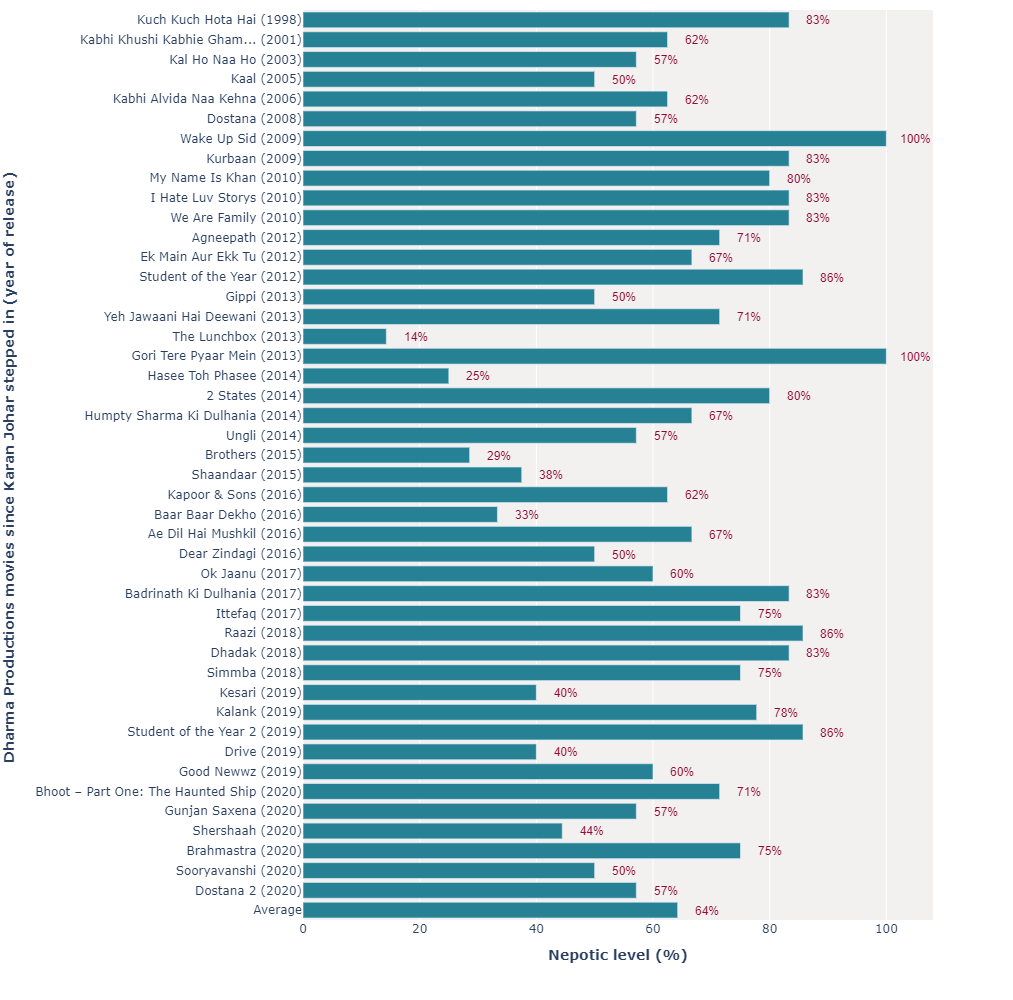

In [292]:
# Visualization
fig = go.Figure(go.Bar(
            x=nepotic_percent,
            y=movies,
            orientation='h',
            marker=dict(
            color=color_teal)
               ))

fig.update_layout(
    autosize=False,
    width=900,
    height=1000,
    xaxis = dict(title="<b>Nepotic level (%)<b>"),
    yaxis = dict(title="<b>Dharma Productions movies since Karan Johar stepped in (year of release) <b>",
                showgrid=False),
    plot_bgcolor= 'rgba(242, 241, 239, 1)',
    margin=go.layout.Margin(
        t=10, #top margin
    )
)

annotations = []

label_text = []
for i, v in enumerate(nepotic_percent):
    label_text.append(str(round(v)))
        
for label, yd, xd in zip(label_text, nepotic_percent, movies):
    # labeling the scatter savings
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd + 5,
                            text=label + '%',
                            font=dict(family='Arial', size=12,
                                      color=color_plum),
                            showarrow=False))
    
fig.update_layout(annotations=annotations)

fig.show()

fig.write_image("kj_movie_nepotic_percentage.png", engine="kaleido", scale = 1.5)

### Analysis #2: Number of movies above a certain nepotic threshold

In [293]:
def get_movie_with_given_nepotic_range(movie_dict, nepotic_treshold_min, nepotic_threshold_max):
    movie_count = 0
    movie_threshold = 0
    for movie in movie_dict:
        movie_count += 1
        movie_info = movie_dict[movie]
        nepotic_percent, nepotic_crew_count, lead_crew_count = get_movie_nepotic_percentage(movie_info)
        if nepotic_percent > nepotic_treshold_min and nepotic_percent <= nepotic_threshold_max:
            movie_threshold += 1
    return movie_threshold, movie_count

# Nepotic values
nepotic_threshold_fifth = 20
nepotic_threshold_quarter = 25
nepotic_threshold_third = 33.3
nepotic_threshold_half = 50
movie_threshold_fifth, movie_count = get_movie_with_given_nepotic_range(dict_movie_info_cleaned, nepotic_threshold_fifth, 100)
movie_threshold_quarter, movie_count = get_movie_with_given_nepotic_range(dict_movie_info_cleaned, nepotic_threshold_quarter, 100)
movie_threshold_third, movie_count = get_movie_with_given_nepotic_range(dict_movie_info_cleaned, nepotic_threshold_third, 100)
movie_threshold_half, movie_count = get_movie_with_given_nepotic_range(dict_movie_info_cleaned, nepotic_threshold_half, 100)

# data = {'Total':movie_count, 'Over 20% nepotic':movie_threshold_fifth, 
#         'Over 25% nepotic': movie_threshold_quarter, 'Over 33.3% nepotic':movie_threshold_third, 
#         'Over 50% nepotic': movie_threshold_half} 

data = {'Total movies':movie_count,
         'Highly nepotic movies': movie_threshold_half,
        'Non-highly nepotic movies': movie_count - movie_threshold_half} 

movies = list(data.keys()) 
values = list(data.values()) 

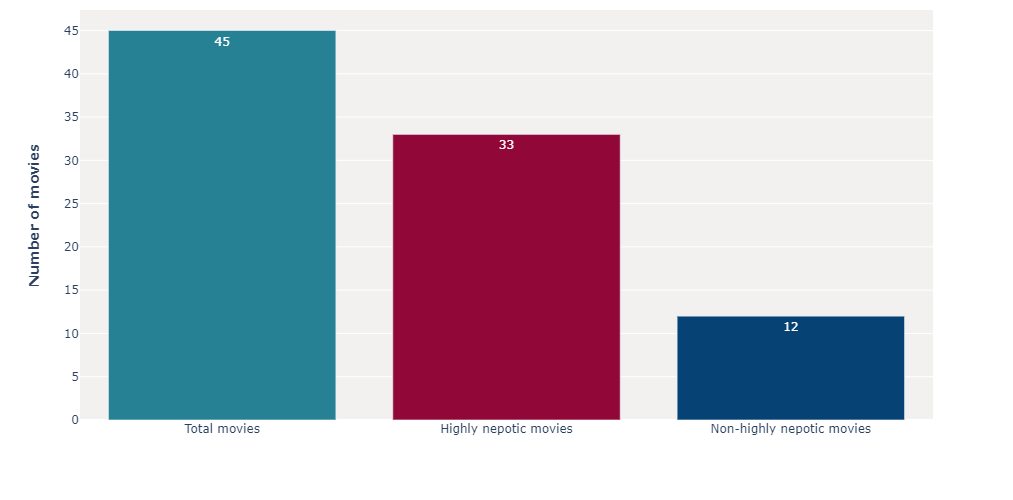

In [294]:
# Visualization
fig = go.Figure(data=[go.Bar(
            x=movies, y=values,
            text=values,
            textposition='auto',
            marker=dict(color=[color_teal, color_plum, '#064273'])
        )])

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis = dict(showgrid = False),
    yaxis = dict(title="<b> Number of movies <b>"),
    plot_bgcolor= 'rgba(242, 241, 239, 1)',
    margin=go.layout.Margin(
        t=10, #top margin
    )
)

fig.show()

fig.write_image("kj_movies_by_nepotic_level.png", engine="kaleido", scale = 2.5)

### Analysis #3: Evolution of the proportion of nepotic movies over time

In [295]:
def get_average_nepotic_level_over_time(movie_dict):
    year_list = []
    avg_nepotic_level_list = []
    ratio_highly_nepotic = []
    sum_nepotic_level = 0
    count = 0
    count_nepotic = 0
    year_current = '1998'
    for movie in movie_dict:
        movie_info = movie_dict[movie]
        movie_year = movie_info['Year']
        if movie_year != year_current:
            avg_nepotic_level_list.append(sum_nepotic_level/count)
            ratio_highly_nepotic.append(count_nepotic/count*100)
            year_list.append(int(year_current))
            year_current = movie_year
        count += 1
        nepotic_percent, nepotic_crew_count, lead_crew_count = get_movie_nepotic_percentage(movie_info)
        sum_nepotic_level += nepotic_percent
        if nepotic_percent > 50:
            count_nepotic += 1
    avg_nepotic_level_list.append(sum_nepotic_level/count)
    ratio_highly_nepotic.append(count_nepotic/count*100)
    year_list.append(int(year_current))
    return avg_nepotic_level_list, year_list, ratio_highly_nepotic
            
avg_nepotic_level_list, year_list, ratio_highly_nepotic = get_average_nepotic_level_over_time(dict_movie_info_cleaned)      


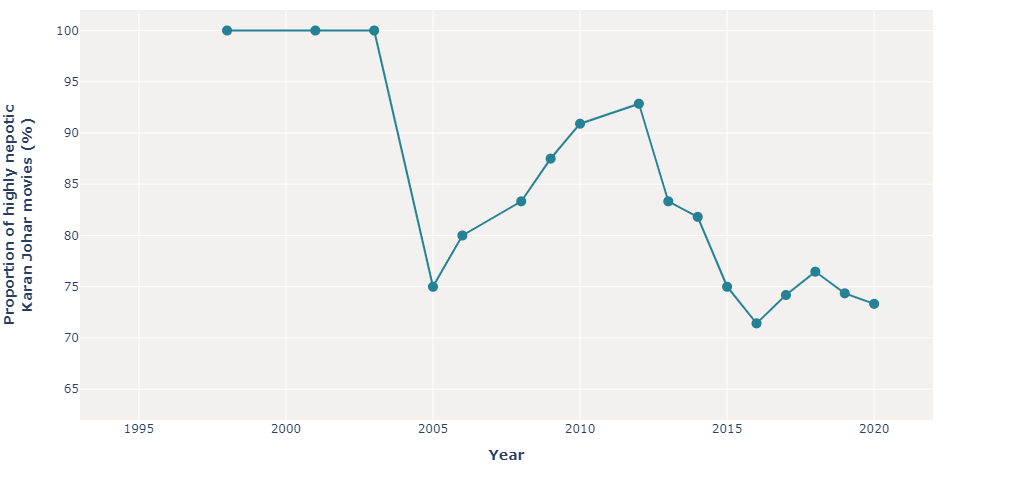

In [296]:
# Visualization

fig = go.Figure(data=go.Scatter(x=year_list, y=ratio_highly_nepotic, marker=dict(size = 10, color=color_teal)) )

fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    xaxis = dict(title="<b> Year <b>", showgrid = True, range = [1993,2022]),
    yaxis = dict(title="<b> Proportion of highly nepotic <br> Karan Johar movies (%) <b>",
                showgrid = True, range = [62,102]),
    plot_bgcolor= 'rgba(242, 241, 239, 1)',
     margin=go.layout.Margin(
        t=10, #top margin
    )
)

fig.show()

fig.write_image("kj_ratio_highly_nepotic_movies.png", engine="kaleido", width = 600, height=500, scale = 2)

### Analysis #4: Success of a movie vs nepotic level

In [297]:
#Manually curated box office verdict list based on boxofficeindia.com
datafile_name = 'bollywood_movies_box_office_verdict.xlsx'
datafile_location = path.join(main_directory, 'database', datafile_name)
df_box_office = pd.read_excel(datafile_location)

In [308]:
verdict_to_value = {'Not Applicable': 0, 'DISASTER': 1, 'FLOP': 2, 'AVERAGE': 3, 'SEMI HIT': 4, 'HIT': 5, 'SUPER HIT': 6, 'BLOCKBUSTER': 7, 'ALL TIME BLOCKBUSTER': 8}

def add_box_office_verdict(movie_dict):
    for movie in movie_dict:
        movie_info = movie_dict[movie]
        if movie in df_box_office['Name'].values:
            movie_info['Box Office Verdict'] = list(df_box_office[df_box_office['Name'] == movie]['Box Office Verdict'].values)[0]
            movie_dict[movie] = movie_info
            #print(movie_dict)
        else:
            print(movie)
            
def extract_movie_verdict_list(movie_dict, nepotic_lim, verdict_lim):
    df_movie_verdict = pd.DataFrame()
    movie_name = []
    nepotic_percent_list = []
    verdict_value_list = []
    outcome_list = []
    for movie in movie_dict:
        movie_info = movie_dict[movie]
        if movie_info['Box Office Verdict'] != 'Not Applicable':
            movie_name.append(movie)
            nepotic_percent = get_movie_nepotic_percentage(movie_info)
            nepotic_percent_list.append(nepotic_percent[0])
            verdict = movie_info['Box Office Verdict']
            verdict_val = verdict_to_value[verdict]
            verdict_value_list.append(verdict_val)
            nepotic_percent = nepotic_percent[0]
            if verdict_val >= verdict_lim and nepotic_percent > nepotic_lim:
                outcome = "Highly nepotic - above average"
            if verdict_val >= verdict_lim and nepotic_percent <= nepotic_lim:
                outcome = "Non-highly nepotic - above average"
            if verdict_val < verdict_lim and nepotic_percent <= nepotic_lim:
                outcome = "Non-highly nepotic - average or below"
            if verdict_val < verdict_lim and nepotic_percent > nepotic_lim:
                outcome = "Highly nepotic - average or below"
            outcome_list.append(outcome)
        else:
            print(movie)
    df_movie_verdict['Name'] = movie_name
    df_movie_verdict['Verdict Value'] = verdict_value_list
    df_movie_verdict['Nepotic Level'] = nepotic_percent_list
    df_movie_verdict['Outcome'] = outcome_list
    return df_movie_verdict
 
verdict_lim = 3.5
nepotic_lim = 50
add_box_office_verdict(dict_movie_info_cleaned) 
df_movie_verdict = extract_movie_verdict_list(dict_movie_info_cleaned, nepotic_lim, verdict_lim)
verdict_text = list(verdict_to_value.keys())

count_ur = 0
count_ul = 0
count_ll = 0
count_lr = 0
for verdict_val, nepotic_lev in zip(df_movie_verdict['Verdict Value'], df_movie_verdict['Nepotic Level']):
    if verdict_val >= verdict_lim and nepotic_lev > nepotic_lim:
        count_ur += 1
    if verdict_val >= verdict_lim and nepotic_lev <= nepotic_lim:
        count_ul += 1
    if verdict_val < verdict_lim and nepotic_lev <= nepotic_lim:
        count_ll += 1
    if verdict_val < verdict_lim and nepotic_lev > nepotic_lim:
        count_lr += 1

Drive
Gunjan Saxena
Shershaah
Brahmastra
Sooryavanshi
Dostana 2


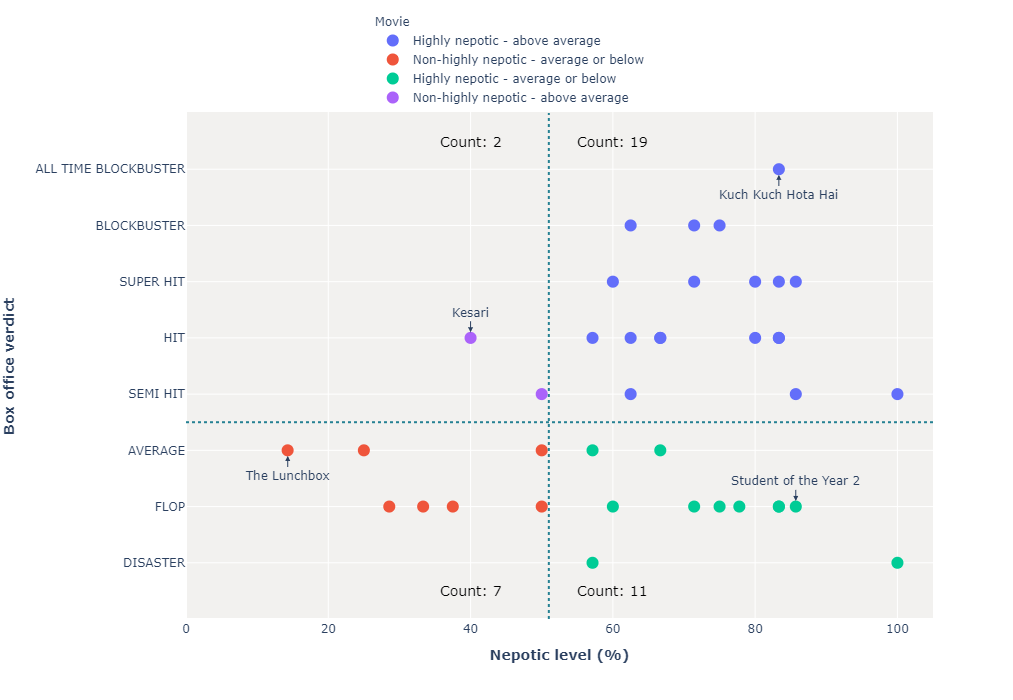

In [305]:
# Visualization
df = px.data.iris()
fig = px.scatter(df_movie_verdict, x="Nepotic Level", y="Verdict Value", color="Outcome")

fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    xaxis = dict(title="<b> Nepotic level (%) <b>", showgrid = True, range = [0,105]),
    yaxis = dict(title="<b> Box office verdict <b>",
                showgrid = True,
                tickmode = 'array',
                tickvals = [1, 2, 3, 4, 5, 6, 7, 8],
                ticktext = verdict_text[1:]),
    plot_bgcolor= 'rgba(242, 241, 239, 1)',
    margin=go.layout.Margin(
        t=10, #top margin
    ),
    legend=dict(
        title_text='Movie',
        x = 0.25,
        y = 1.2),
    shapes = [
        {
            'type': 'line',
            'x0': 51,
            'y0': 0,
            'x1': 51,
            'y1': 9,
            'line': {
                'color': color_teal,
                'width': 2,
                'dash': "dot"
            },
        },
        {
            'type': 'line',
            'x0': 0,
            'y0': 3.5,
            'x1': 110,
            'y1': 3.5,
            'line': {
                'color': color_teal,
                'width': 2,
                'dash': "dot"
            },
        },
        
    ],
    annotations=[
        dict(
            x=83.333,
            y=7.9,
            xref="x",
            yref="y",
            text="Kuch Kuch Hota Hai",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=20
        ),
        dict(
            x=40,
            y=5.1,
            xref="x",
            yref="y",
            text="Kesari",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=-20
        ),
        dict(
            x=14.3,
            y=2.9,
            xref="x",
            yref="y",
            text="The Lunchbox",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=20
        ),
        dict(
            x=85.71,
            y=2.1,
            xref="x",
            yref="y",
            text="Student of the Year 2",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=-20
        ),
        dict(
            x=60,
            y=8.5,
            xref="x",
            yref="y",
            text= "Count: " + str(count_ur),
            showarrow=False,
            font_size = 14,
            font_color = 'black'
        ),
        dict(
            x=40,
            y=8.5,
            xref="x",
            yref="y",
            text= "Count: " + str(count_ul),
            showarrow=False,
            font_size = 14,
            font_color = 'black'
        ),
        dict(
            x=40,
            y=0.5,
            xref="x",
            yref="y",
            text= "Count: " + str(count_ll),
            showarrow=False,
            font_size = 14,
            font_color = 'black'
        ),
        dict(
            x=60,
            y=0.5,
            xref="x",
            yref="y",
            text= "Count: " + str(count_lr),
            showarrow=False,
            font_size = 14,
            font_color = 'black'
        )
        
    ]
)

fig.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))

fig.update_traces(textposition='top center')

fig.show()

fig.write_image("kj_movies_success_vs_nepotic_level.png", engine="kaleido", scale = 2)

### Analysis #5: Equal opportunities in new crew members launched by Dharma

In [301]:
def get_list_crew_launched(movie_dict):
    crew_list = []
    movie_list = []
    crew_role_list = []
    for movie, movie_info in movie_dict.items():
        movie_list.append(movie)
        for item in movie_info:
            if item in ['Directors', 'Producers', 'Actors']:
                el = movie_info[item]
                for crew in el:
                    if crew not in crew_list:
                        crew_role_list.append(item)
                        crew_list.append(crew)

    crew_launched = []
    crew_launched_movie = []
    crew_connection = []
    crew_connection_value = []
    crew_launched_role = [] 
    for crew_name, crew_role in zip(crew_list, crew_role_list):
        crew_found = 0
        if crew_name in df_database['Name'].values: 
            found_in = 'Name'
            crew_found += 1
        elif crew_name in df_database['Alternate Name'].values:
            found_in = 'Alternate Name'
            crew_found += 1
            
        if crew_found == 1:
            first_movie = df_database.loc[df_database[found_in] == crew_name, 'First Bollywood Movie in Lead Role'].values[0]
            if first_movie in movie_list:
                crew_launched.append(crew_name)
                crew_launched_movie.append(first_movie)
                crew_launched_role.append(crew_role)
                connection = df_database.loc[df_database[found_in] == crew_name, 'Known Bollywood Relation'].values[0]
                crew_connection.append(connection)
                if connection != 'None':
                    crew_connection_value.append(1)
                else:
                     crew_connection_value.append(0)   
        else:
            print(crew_name)

    df_crew_launched = pd.DataFrame()
    df_crew_launched['Name'] = crew_launched 
    df_crew_launched['Movie Launched'] = crew_launched_movie 
    df_crew_launched['Role'] = crew_launched_role
    df_crew_launched['Known Bollywood Relation'] = crew_connection
    df_crew_launched['Relation Value'] = crew_connection_value
    return df_crew_launched

df_crew_launched = get_list_crew_launched(dict_movie_info_cleaned)  

df_crew_launched = df_crew_launched[df_crew_launched['Name']!= 'Hiroo Yash Johar']
role_list = ['Actor', 'Actor', 'Director', 'Director', 'Producer', 'Producer']
nepotic_value = ['Product of nepotism', 'Outsider', 'Product of nepotism', 'Outsider', 'Product of nepotism', 'Outsider']

actor_nepotic = len(df_crew_launched.loc[(df_crew_launched['Role'] == 'Actors') & (df_crew_launched['Known Bollywood Relation'] != 'None')])
actor_non_nepotic = len(df_crew_launched.loc[(df_crew_launched['Role'] == 'Actors') & (df_crew_launched['Known Bollywood Relation'] == 'None')])
director_nepotic = len(df_crew_launched.loc[(df_crew_launched['Role'] == 'Directors') & (df_crew_launched['Known Bollywood Relation'] != 'None')])
director_non_nepotic = len(df_crew_launched.loc[(df_crew_launched['Role'] == 'Directors') & (df_crew_launched['Known Bollywood Relation'] == 'None')])
producer_nepotic = len(df_crew_launched.loc[(df_crew_launched['Role'] == 'Producers') & (df_crew_launched['Known Bollywood Relation'] != 'None')])
producer_non_nepotic = len(df_crew_launched.loc[(df_crew_launched['Role'] == 'Producers') & (df_crew_launched['Known Bollywood Relation'] == 'None')])

total_list = [actor_nepotic, actor_non_nepotic, director_nepotic, director_non_nepotic, producer_nepotic, producer_non_nepotic]

df_crew_launched_structured = pd.DataFrame()
df_crew_launched_structured['Role'] = role_list
df_crew_launched_structured['Nepotic Status'] = nepotic_value
df_crew_launched_structured['Number'] = total_list

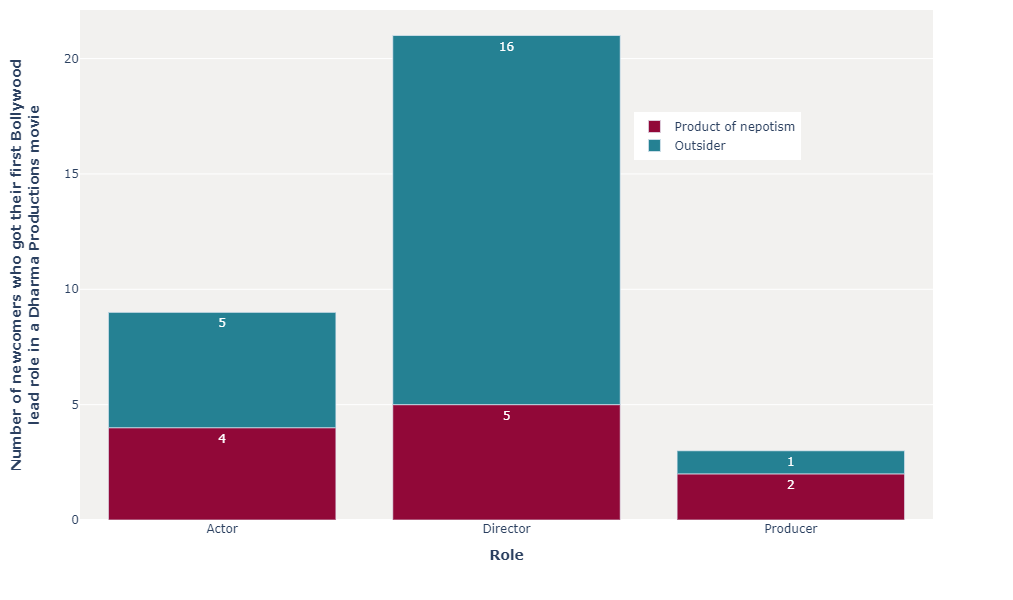

In [302]:
# Visualize
fig = px.bar(df_crew_launched_structured, 
             x="Role", 
             y="Number", 
             color="Nepotic Status",
             text='Number',
             color_discrete_sequence = [color_plum, color_teal],
            )

fig.update_layout(
    autosize=False,
    width=650,
    height=600,
    xaxis = dict(title="<b> Role <b>", showgrid = False),
    yaxis = dict(title="<b> Number of newcomers who got their first Bollywood <br> lead role in a Dharma Productions movie <b>",
                showgrid = True),
    plot_bgcolor= 'rgba(242, 241, 239, 1)',
    margin=go.layout.Margin(
        t=10, #top margin
    ),
    legend=dict(
        title_text='',
        x=0.65,
        y=0.8)
)

fig.show()

fig.write_image("kj_new_comers.png", engine="kaleido", scale = 2)

In [285]:
#Save
save_file = 'launched_crew_list.xlsx'
writer = ExcelWriter(save_file)

role = 'Actors'
df_crew_launched[df_crew_launched['Role']==role].to_excel(writer, sheet_name = role, index=False)
role = 'Directors'
df_crew_launched[df_crew_launched['Role']==role].to_excel(writer, sheet_name = role, index=False)
role = 'Producers'
df_crew_launched[df_crew_launched['Role']==role].to_excel(writer, sheet_name = role, index=False)

writer.save()